# ML Dust Project - 2pop Size Distribution
## Install Lightning, Load Packages


In [2]:
import time
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import astropy.units as u
import random
from scipy.ndimage import gaussian_filter1d
from torchmetrics import MeanAbsolutePercentageError
import matplotlib.gridspec as gridspec

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.bf']
plt.rcParams['axes.labelsize'] =8
plt.rcParams['xtick.labelsize']=8
plt.rcParams['ytick.labelsize']=8
plt.rcParams['legend.fontsize']=8
plt.rcParams['axes.linewidth']=1
plt.rcParams['ytick.major.width']=1
plt.rcParams['ytick.minor.width']=0.5
plt.rcParams['xtick.major.width']=1
plt.rcParams['xtick.minor.width']=0.5

FigsizeHalf = (3.36481291667,2)
FigsizeFull = (7.12663097223,3)

/home/thomas/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(torch.utils.cmake_prefix_path)

/home/thomas/.local/lib/python3.8/site-packages/torch/share/cmake


## Define a Plotting Function and a Function Printing Model Parameters

In [4]:
def plot_model(modnum, mode = 'default'):
    fig, ax = plt.subplots(2,3, figsize=(16,10))

    if mode == 'default':
        Model  = Twopop
        dModdt = d_Twopop_dt
    elif mode == 'std':
        Model = Twopop_scaled
        dModdt = d_Twopop_dt_scaled
    elif mode == 'normed':
        Model = Twopop_normed
        dModdt = d_Twopop_dt_normed
  
    ax[0,0].plot(Model[150*modnum:int((modnum*150+150)),0], linewidth=3)
    #ax[0,0].set_xlabel('Time [yr]')
    ax[0,0].set_ylabel('Max. Particle Size [cm]')

    ax[0,1].plot(Model[150*modnum:int((modnum*150+150)),1], linewidth=3)
    #ax[0,1].set_xlabel('Time [yr]')
    ax[0,1].set_ylabel('2pop Densities $\sigma_0, \sigma_1 \, [\mathrm{g/cm^2}]$')

    ax[0,2].plot(Model[150*modnum:int((modnum*150+150)),2], linewidth=3)
    #ax[0,2].set_xlabel('Time [yr]')
    ax[0,2].set_ylabel('Power Law Index')

    ax[1,0].plot(dModdt[150*modnum:int((modnum*150+150)),0], linewidth=3)
    #ax[1,0].set_xlabel('Time [yr]')
    ax[1,0].set_ylabel('$\partial_t$ Max. Particle Size [cm]')

    ax[1,1].plot(dModdt[150*modnum:int((modnum*150+150)),1], linewidth=3)
    #ax[1,1].set_xlabel('Time [yr]')
    ax[1,1].set_ylabel('$\partial_t$ 2pop Densities $\sigma_0, \sigma_1 \, [\mathrm{g/cm^2}]$')

    # ax[1,2].plot(dModdt[150*modnum:int((modnum*150+150)),2], linewidth=3)
    # #ax[1,2].set_xlabel('Time [yr]')
    # ax[1,2].set_ylabel('$\partial_t$ Power Law Index')

    fig.tight_layout()

    del Model, dModdt

def print_sample(Models, i):
    print('Stellar Properties:\n--------------------------------------------------------')
    print("Stellar Mass:\t\t", Models[i,0], r'Msol')
    print("Stellar Temperature:\t", Models[i,1], r'K')
    print('\nGlobal Disk Properties:\n--------------------------------------------------------')
    print("Disk Mass:\t\t", Models[i,2], r'Msol')
    print("Turbulent Alpha:\t", Models[i,3])
    print('\nLocal Disk Properties:\n--------------------------------------------------------')
    print("Distance to Star:\t", Models[i,4], r'au')
    print("Local Disk Temperature:\t", Models[i,5], r'K')
    print("Local Column Density:\t", Models[i,6], r'g/cm^2')
    print("Dust-to-Gas Ratio:\t", Models[i,7])
    print("Fragmentation Limit:\t", Models[i,8], 'cm')
    print("Dust Growth Timescale:\t", Models[i,10]/((u.yr).to(u.s)), 't_orb = ', 2*np.pi/Models[i,9]/yr, 'yr')
    print("Initial Maximum Size:\t", Models[i,11], "cm")

## Load 2pop Dust evolution Models

In [14]:
################################################################################
############################## Sim. Parameters #################################
#################     params[0] = M_star [M_sun]     ###########################
#################     params[1] = Tstar [K]          ###########################
#################     params[2] = M_disk [M_sun]     ###########################
#################     params[3] = turb. alpha        ###########################
#################     params[4] = dist. to star [au] ###########################
#################     params[5] = T_disk [K]         ###########################
#################     params[6] = Col. Den. [g/cm^2)]  #########################
#################     params[7] = d-to-g ratio       ###########################
#################     params[8] = afrag [cm]         ###########################
#################     params[9] = OmegaK [1/s]       ###########################
#################     params[10]= Growth time [s]    ###########################
################################################################################

params = np.load("Parameters/Parameters.npy")[:,:11]
np.savetxt("Parameters.csv", params, delimiter=",", header='M_star [M_sun], T_star [K], M_disk [M_sun], alpha, R [au], T_disk [K], Sigma_gas [g/cm^2], eps, afrag [cm], OmegaK [1/s], tgr [s]')
Params150 = np.repeat(params, 150, axis=0).T

################################################################################
############################ Load as single file ###############################
#################          twopop[0] = time [yr]     ###########################
#################          twopop[1] = amax [cm]     ###########################
#################          twopop[2] = sig0 [g/cm^2] ###########################
#################          twopop[3] = sig1 [g/cm^2] ###########################
#################          twopop[4] = p             ###########################
################################################################################

twopop     = np.load("Twopop.npy")

np.savetxt("Twopop.csv", twopop.T, delimiter=",", header='time [yr], amax [cm], sig0 [g/cm^2], sig1 [g/cm^2], p')
twopop[0] *= (u.yr).to(u.s) / Params150[10,:] # Convert time to units of local growth time scale

######################## Apply another Gaussian Filter #########################
for i in range(10000):
    twopop[1, 150*i:int((i*150+150))] = gaussian_filter1d(twopop[1, 150*i:int((i*150+150))], sigma=4)
    twopop[2, 150*i:int((i*150+150))] = gaussian_filter1d(twopop[2, 150*i:int((i*150+150))], sigma=4)
    twopop[3, 150*i:int((i*150+150))] = params[i,6]*params[i,7] - twopop[2, 150*i:int((i*150+150))]
    twopop[4, 150*i:int((i*150+150))] = np.log(twopop[3, 150*i:int((i*150+150))]/twopop[2, 150*i:int((i*150+150))]) / np.log(twopop[1, 150*i:int((i*150+150))]/(np.sqrt(1e-5*twopop[1, 150*i:int((i*150+150))]))) - 4.0
################################################################################

twopop2D   = twopop.reshape((5,10000,150))

################################################################################
################# Prepare to contain the following features ####################
#################          Twopop[0] = log(amax)            ####################
#################          Twopop[1] = sig1/sigtot          ####################
#################          Twopop[2] = p                    ####################
################################################################################

dtg150    = Params150[7,:]
sigg150   = Params150[6,:]

Twopop = twopop[[0,1,3,4],:]
Twopop[2] /= (sigg150*dtg150)

Twopop[1:3]         = np.log10(Twopop[1:3])
twopop2D[[1,3],:,:] = np.log10(twopop2D[[1,3],:,:])

# twopop2D[0,:,0] = 1e-10

def scale(data):
    return np.sign(data) * np.abs(data)**0.1

def de_scale(data):
    return np.sign(data) * np.abs(data)**10.0

def normalize(data, train_size, offset):
    # data neads to have shape (#samples, #features)
    data_min  = (data[:,:train_size]).min(axis=1)
    data_max  = (data[:,:train_size]).max(axis=1)
    print(np.shape(data_min))
    data_norm = (data - data_min[:,None]) / (data_max[:, None] - data_min[:, None]) + offset
    return data_norm, data_min, data_max

def normalize_one(data, data_min, data_max, offset):
    return (data - data_min) / (data_max - data_min) + offset

def de_normalize(data_norm, data_min, data_max, offset):
    # data neads to have shape (#samples, #features)
    data = (data_norm - offset) * (data_max[:] - data_min[:]) + data_min[:]
    return data

d_Twopop_dt = np.zeros((2,1500000))
for i in range(10000):
    d_Twopop_dt[:, 150*i:int((i*150+150))] = np.gradient(twopop2D[:,i,:], twopop2D[0,i,:], axis=-1)[[1,3],:]
    sign                                   = np.sign(d_Twopop_dt[:, 150*i:int((i*150+150))])
    d_Twopop_dt[:, 150*i:int((i*150+150))] = scale(d_Twopop_dt[:, 150*i:int((i*150+150))])

Twopop = np.vstack((Twopop[1:], Params150))

############################# Normalize to 0-1 #################################

train_size = int(0.8 * len(Twopop.T))
offset_X = 0.0
offset_Y = 0.1
Twopop_normed, Twopop_min, Twopop_max = normalize(Twopop, train_size, offset_X)
d_Twopop_dt_normed, d_Twopop_dt_min, d_Twopop_dt_max = normalize(d_Twopop_dt, train_size, offset_Y)

######################### Convert to pytorch tensor ############################

Twopop      = torch.tensor(Twopop.T, dtype=torch.float)
d_Twopop_dt = torch.tensor(d_Twopop_dt.T, dtype=torch.float)

# Twopop_scaled      = torch.tensor(Twopop_scaled.T, dtype=torch.float)
# d_Twopop_dt_scaled = torch.tensor(d_Twopop_dt_scaled.T, dtype=torch.float)

Twopop_normed      = torch.tensor(Twopop_normed.T, dtype=torch.float)
d_Twopop_dt_normed = torch.tensor(d_Twopop_dt_normed.T, dtype=torch.float)

print(np.shape(Twopop), np.shape(d_Twopop_dt))

(14,)
(2,)
torch.Size([1500000, 14]) torch.Size([1500000, 2])


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


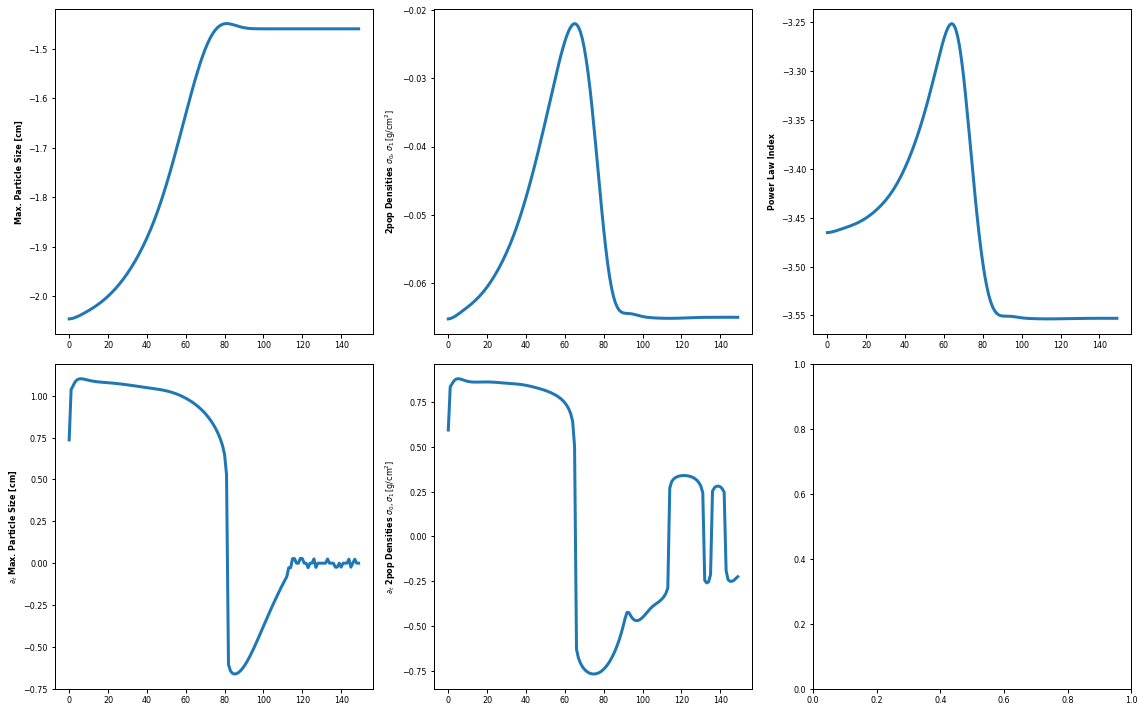

In [5]:
#######################################################
#################### Plot a Model #####################
#######################################################

ModelNum = 9900
plot_model(ModelNum, 'default')

## Defining the Neural Network

In [6]:
import pytorch_lightning as pl

class NeuralNetwork(pl.LightningModule):
    def __init__(self, n_in, n_out, *, n_hidden=100, learning_rate):
        super().__init__()

        self.learning_rate = learning_rate

        self.neural_net = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_out)
        )

        # Can manually declare parameters like so:
        self.scale = nn.Parameter(torch.tensor(1.0))

        # All models and parameters created to `self`
        # are optimized automatically!
        
    def forward(self, x):
        x = x * self.scale
        return self.neural_net(x)
    
    #######################################################
    # Additional functions needed for Lightning: ##########
    #######################################################
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_predicted = self.forward(x)
        assert y_predicted.shape == y.shape
        ######### Differnt Loss Functions ##########
        #loss = ((y_predicted - y) ** 2).mean() # MSE
        # loss = ((y_predicted - y).abs()).mean()  # MAE
        #loss = ((y_predicted - y) ** 2 / (y)**2).mean() # Xi^2
        loss = ((y_predicted - y).abs()/y.abs()).mean() # MAPE
        #loss = ((y_predicted - y).abs()/(y_predicted.abs()+y.abs())).mean() # SMAPE
        #loss = (torch.log(y_predicted.abs()) - torch.log(y.abs())).abs().mean() # log error
        if self.train:
            # Optional:
            self.log("train_loss", loss, prog_bar=True)  # Display logged quantity 
            # Can log any other quantity!
        return loss

    def validation_step(self, batch, batch_idx):
        # Same code:
        return self.training_step(batch, batch_idx)

    def test_step(self, batch, batch_idx):
        # Same code:
        return self.training_step(batch, batch_idx)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=(self.learning_rate))
        #return torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        
    #######################################################
    #######################################################

In [7]:
####################### Want to learn next timestep ############################
################ Split into train/test datasets and loaders:####################

# #Parameters + 2pop Dust Size Distr.
# n_in = 3
# #2pop time derivatives
# n_out = 3

# train_size = int(0.8 * len(Twopop_i))
# train_dataset = TensorDataset(Twopop_i[:train_size,:], Twopop_ip1[:train_size,:])
# test_dataset  = TensorDataset(Twopop_i[train_size:,:], Twopop_ip1[train_size:,:])

####################### Want to learn time dervative ###########################
################ Split into train/test datasets and loaders:####################

X = Twopop_normed
Y = d_Twopop_dt_normed
print(np.shape(X), np.shape(Y))

# Parameters + 2pop Dust Size Distr.
n_in = 14
# 2pop time derivatives
n_out = 2

train_dataset = TensorDataset(X[:train_size,:], Y[:train_size,:])
test_dataset  = TensorDataset(X[train_size:,:], Y[train_size:,:])

torch.Size([1500000, 14]) torch.Size([1500000, 2])


In [8]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

train_loader = DataLoader(train_dataset, shuffle=True, num_workers=2, batch_size=1000, worker_init_fn=seed_worker)
test_loader = DataLoader(test_dataset, shuffle=True, num_workers=2, batch_size=1000, worker_init_fn=seed_worker)

In [9]:
model = NeuralNetwork(n_in=n_in, n_out=n_out, n_hidden=100, learning_rate=1e-3)
# model.load_state_dict(torch.load('MLModels/LongRun_Continued.pth'))
# model.load_state_dict(torch.load('MLModels/LongRun_NoScaleNewLoss.pth'))
model.load_state_dict(torch.load('MLModels/LongRun.pth'))
model.eval()

NeuralNetwork(
  (neural_net): Sequential(
    (0): Linear(in_features=14, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

8000
8200
8400
8600
8800
9000
9200
9400
9600
9800


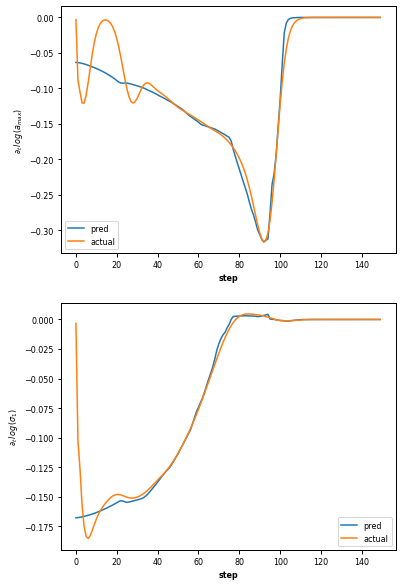

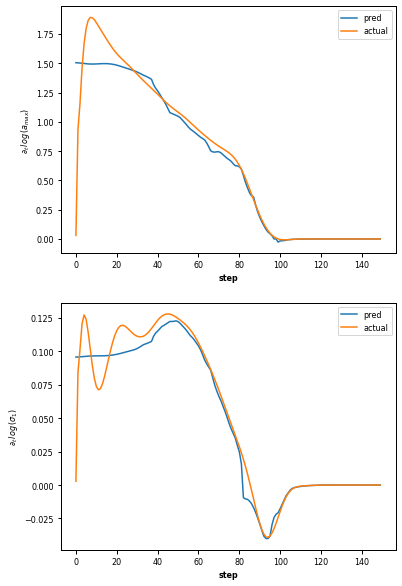

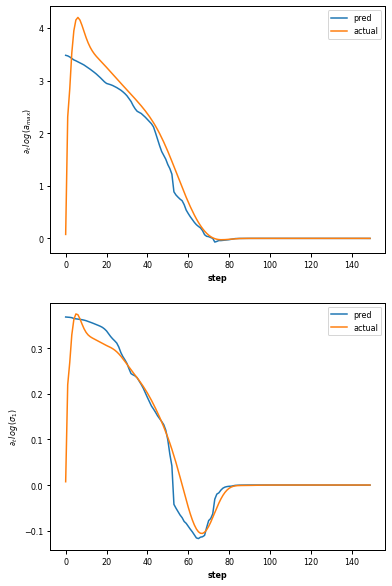

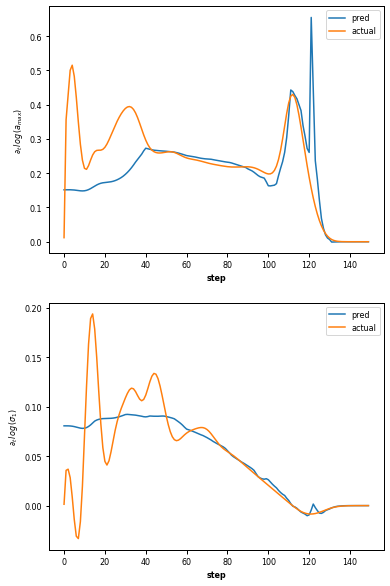

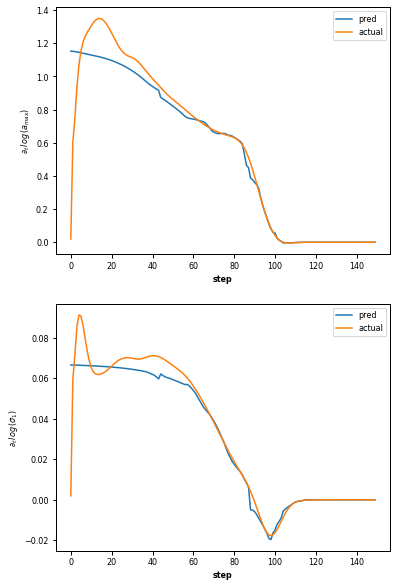

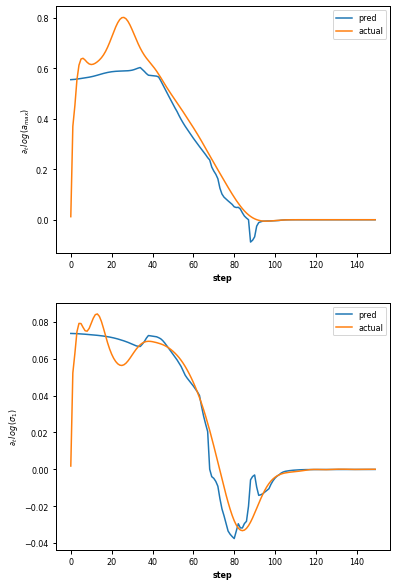

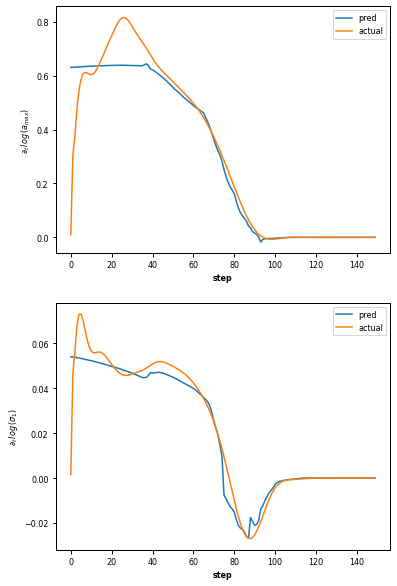

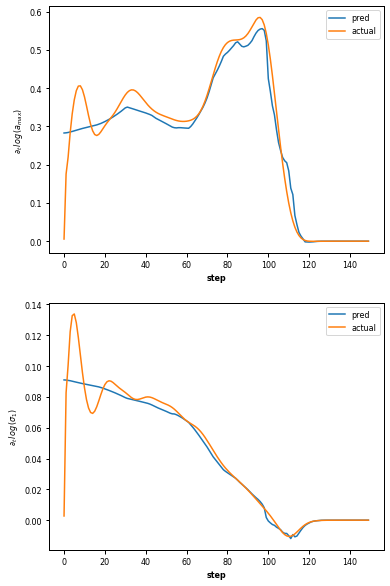

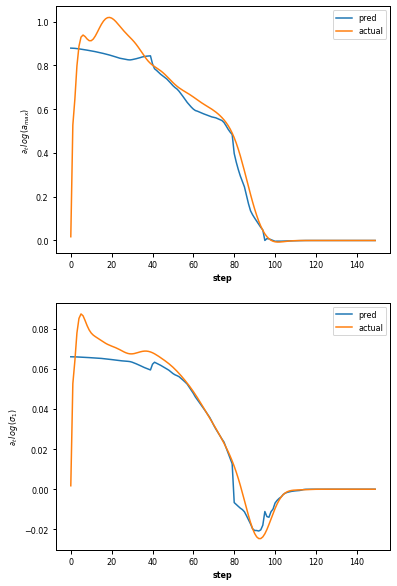

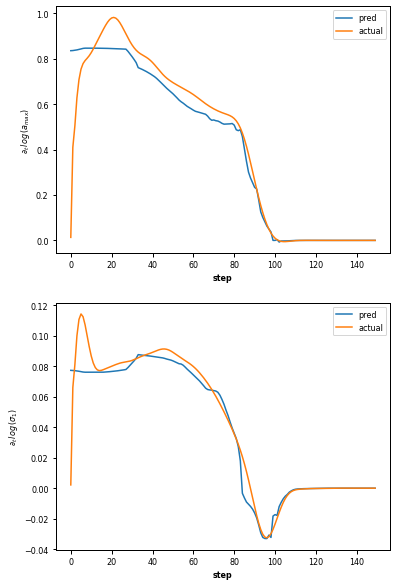

In [10]:
act  = np.zeros((150,2))
pred = np.zeros((150,2))

for j in np.arange(8000, 10000, 200):
    k=0
    for i in range(150*j,int((j*150+150))):
        pred[k]   = de_normalize(np.array(model(Twopop_normed[i]).data).T, d_Twopop_dt_min, d_Twopop_dt_max, offset_Y)
        sign_pred = np.sign(pred[k])
        pred[k]   = de_scale(pred[k])

        act[k]  = d_Twopop_dt[i,:2]
        sign_act = np.sign(act[k])
        act[k]   = de_scale(act[k])
        k+=1
        
    fig, ax = plt.subplots(2,1, figsize=(6,10))

    ax[0].plot(pred[:,0], label='pred')
    ax[0].plot(act[:,0], label='actual')
    ax[0].legend()
    ax[0].set_xlabel('step')
    ax[0].set_ylabel('$\partial_t \,log\,(a_{max})$')

    ax[1].plot(pred[:,1], label='pred')
    ax[1].plot(act[:,1], label='actual')
    ax[1].legend()
    ax[1].set_xlabel('step')
    ax[1].set_ylabel('$\partial_t \,log\,(\sigma_1)$')

    print(j)

## Test ML-Gradients + Numerical Integration 

In [26]:
%%time
modnum = 8888

twopop_act = Twopop[modnum*150:modnum*150+150, :3]

twopop_num      = np.zeros((150, 14))
d_twopop_dt_num = np.zeros((150, 2))

d_twopop_dt_pred = np.zeros((150, 2))
d_twopop_dt_act = np.zeros((150, 2))

time = twopop2D[0,modnum,:]
dt   = np.diff(time)

k=0
for i in range(150*modnum,int((modnum*150+149))):
    ##############################################################################
    ############# Collect actual data and prediction on the way ##################
    ##############################################################################
    d_twopop_dt_pred[k]   = de_normalize(np.array(model(Twopop_normed[i]).data).T, d_Twopop_dt_min, d_Twopop_dt_max, offset_Y)
    d_twopop_dt_pred[k]   = de_scale(d_twopop_dt_pred[k])

    d_twopop_dt_act[k]  = de_scale(d_Twopop_dt[i,:2])

    ##############################################################################
    #################### if k==0, set initial condtion ###########################
    ################# fill up twopop_num[3:] with parameters #####################
    ##############################################################################
    if k==0:
        twopop_num[0,:]  = Twopop[i,:]
        twopop_num[:,3:] = Twopop[i,3:]

    ##############################################################################
    #################### Numerically Integrate One Step ##########################
    ############################################################################## 

    tp_normed = normalize_one(twopop_num[k,:], Twopop_min, Twopop_max, offset_X)
    d_twopop_dt_num[k] = de_scale(de_normalize(np.array(model(torch.tensor(tp_normed, dtype=torch.float)).data).T, d_Twopop_dt_min, d_Twopop_dt_max, offset_Y))

    twopop_num[k+1, :2] = np.maximum(-4.9, twopop_num[k, :2] + dt[k]*d_twopop_dt_num[k])
    
    amax = 10**twopop_num[k+1, 0]
    sigtot = dtg150[150*modnum] * sigg150[150*modnum] 
    sig1 = np.maximum(0.01, np.minimum(10**twopop_num[k+1, 1], 0.99)) * dtg150[150*modnum] * sigg150[150*modnum]
    sig0 = sigtot - sig1
    twopop_num[k+1, 2]  = np.maximum(-5, np.log(sig1/sig0)/np.log(amax/np.sqrt(amax*1e-5)) - 4.0)
    # print(amax, sig1/sigtot, sig0/sigtot, twopop_num[k+1, 2])

    k+=1

CPU times: user 78.1 ms, sys: 0 ns, total: 78.1 ms
Wall time: 71 ms


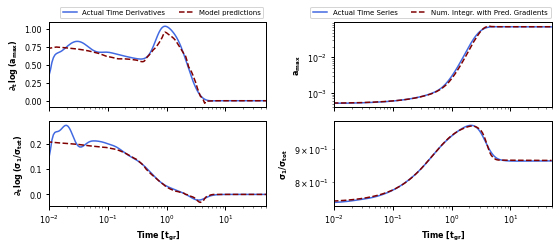

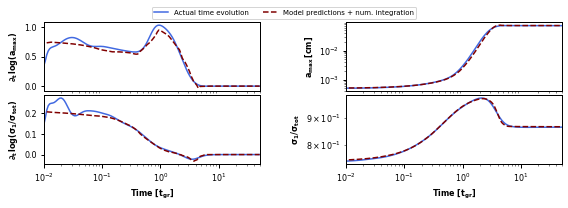

In [28]:
fig, ax = plt.subplots(2,2, figsize=(8,4.5), sharex=True)

# ax[0,0].semilogx(time, d_twopop_dt_pred[:,0], label='Prediction from Sim. Reuslts', color='k')
ax[0,0].semilogx(time, d_twopop_dt_act[:,0], label='Actual Time Derivatives', color='royalblue')
ax[0,0].semilogx(time, d_twopop_dt_num[:,0], label='Model predictions', color='maroon', linestyle='--')
# ax[0,0].set_ylim(-0.1,2)
# ax[0,0].set_yscale('symlog', linthresh=1e-5)
ax[0,0].set_ylabel('$\mathbf{\partial_t \,log\,(a_{\mathbf{max}})}$')

# ax[1,0].semilogx(time, d_twopop_dt_pred[:,1], color='k')
ax[1,0].semilogx(time, d_twopop_dt_act[:,1], color='royalblue')
ax[1,0].semilogx(time, d_twopop_dt_num[:,1], color='maroon', linestyle='--')
ax[1,0].set_ylabel(r'$\mathbf{\partial_t \,log\,(\sigma_1/\sigma_{\mathbf{tot}})}$')
ax[1,0].set_xlabel(r'Time [$\mathbf{t_{\mathbf{gr}}}$]')

ax[0,1].loglog(time, 10**twopop_act[:,0], label="Actual Time Series", color='royalblue')
ax[0,1].loglog(time, 10**twopop_num[:,0], label="Num. Integr. with Pred. Gradients", color='maroon', linestyle='--')
ax[0,1].set_ylabel('$\mathbf{a_{\mathbf{max}}}$')

ax[1,1].loglog(time, 10**twopop_act[:,1], color='royalblue')
ax[1,1].loglog(time, 10**twopop_num[:,1], color='maroon', linestyle='--')
ax[1,1].set_ylabel(r'$\mathbf{\sigma_1/\sigma_{\mathbf{tot}}}$')
ax[1,1].set_xlabel(r'Time [$\mathbf{t_{\mathbf{gr}}}$]')

ax[0,0].set_xlim(1e-2,50)

# ax[2,1].semilogx(time, twopop_num[:,2])
# ax[2,1].semilogx(time, twopop_act[:,2])
# ax[2,1].set_xlabel('time [yr]')
# ax[2,1].set_ylabel('$p$')

ax[0,1].legend(ncol=2, loc=(-0.11,1.05), fontsize=7)
ax[0,0].legend(ncol=2, loc=(0.05,1.05), fontsize=7)

# ax[0,1].legend(ncol=2, loc=(0.65,1.05), fontsize=7, title='Fragmenting Particles')

fig.tight_layout(rect=[0,0,1.0,0.8])

# plt.savefig("Twopop_Shr.pdf", bbox_inches="tight")



fig = plt.figure(figsize=(8,3))

outer  = gridspec.GridSpec(1, 1, figure=fig, wspace=0.0)
inner1 = outer[0].subgridspec(2, 2, wspace=0.4, hspace=0.05)

ax00  = fig.add_subplot(inner1[0,0])
ax01  = fig.add_subplot(inner1[0,1])
ax10  = fig.add_subplot(inner1[1,0])
ax11  = fig.add_subplot(inner1[1,1])

ax00.semilogx(time, d_twopop_dt_act[:,0], label='Actual time evolution', color='royalblue')
ax00.semilogx(time, d_twopop_dt_num[:,0], label='Model predictions + num. integration', color='maroon', linestyle='--')
ax00.set_ylabel('$\mathbf{\partial_t \,log(a_{\mathbf{max}})}$')

ax10.semilogx(time, d_twopop_dt_act[:,1], color='royalblue')
ax10.semilogx(time, d_twopop_dt_num[:,1], color='maroon', linestyle='--')
ax10.set_ylabel(r'$\mathbf{\partial_t \,log(\sigma_1/\sigma_{\mathbf{tot}})}$')

ax01.loglog(time, 10**twopop_act[:,0], label="Actual Time Series", color='royalblue')
ax01.loglog(time, 10**twopop_num[:,0], label="Num. Integr. with Pred. Gradients", color='maroon', linestyle='--')
ax01.set_ylabel('$\mathbf{a_{\mathbf{max}}  \, [cm]}$')

ax11.loglog(time, 10**twopop_act[:,1], color='royalblue')
ax11.loglog(time, 10**twopop_num[:,1], color='maroon', linestyle='--')
ax11.set_ylabel(r'$\mathbf{\sigma_1/\sigma_{\mathbf{tot}}}$')

ax00.set_xlim(1e-2,50)
ax01.set_xlim(1e-2,50)
ax10.set_xlim(1e-2,50)
ax11.set_xlim(1e-2,50)
ax00.set_xticks([])
ax01.set_xticks([])
ax00.legend(ncol=2, loc=(0.5,1.05), fontsize=7)

ax10.set_xlabel(r'Time [$\mathbf{t_{\mathbf{gr}}}$]')
ax11.set_xlabel(r'Time [$\mathbf{t_{\mathbf{gr}}}$]')

outer.tight_layout(fig)

plt.savefig("2popRes.pdf", bbox_inches="tight")

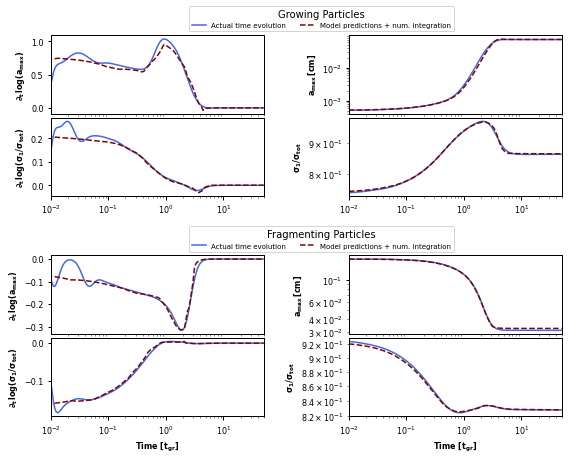

In [13]:
modnum = 8888

twopop_act = Twopop[modnum*150:modnum*150+150, :3]

twopop_num      = np.zeros((150, 14))
d_twopop_dt_num = np.zeros((150, 2))

d_twopop_dt_pred = np.zeros((150, 2))
d_twopop_dt_act = np.zeros((150, 2))

time = twopop2D[0,modnum,:]
dt   = np.diff(time)

k=0
for i in range(150*modnum,int((modnum*150+149))):
    ##############################################################################
    ############# Collect actual data and prediction on the way ##################
    ##############################################################################
    d_twopop_dt_pred[k]   = de_normalize(np.array(model(Twopop_normed[i]).data).T, d_Twopop_dt_min, d_Twopop_dt_max, offset_Y)
    d_twopop_dt_pred[k]   = de_scale(d_twopop_dt_pred[k])

    d_twopop_dt_act[k]  = de_scale(d_Twopop_dt[i,:2])

    ##############################################################################
    #################### if k==0, set initial condtion ###########################
    ################# fill up twopop_num[3:] with parameters #####################
    ##############################################################################
    if k==0:
        twopop_num[0,:]  = Twopop[i,:]
        twopop_num[:,3:] = Twopop[i,3:]

    ##############################################################################
    #################### Numerically Integrate One Step ##########################
    ############################################################################## 

    tp_normed = normalize_one(twopop_num[k,:], Twopop_min, Twopop_max, offset_X)
    d_twopop_dt_num[k] = de_scale(de_normalize(np.array(model(torch.tensor(tp_normed, dtype=torch.float)).data).T, d_Twopop_dt_min, d_Twopop_dt_max, offset_Y))

    twopop_num[k+1, :2] = np.maximum(-4.9, twopop_num[k, :2] + dt[k]*d_twopop_dt_num[k])
    
    amax = 10**twopop_num[k+1, 0]
    sigtot = dtg150[150*modnum] * sigg150[150*modnum] 
    sig1 = np.maximum(0.01, np.minimum(10**twopop_num[k+1, 1], 0.99)) * dtg150[150*modnum] * sigg150[150*modnum]
    sig0 = sigtot - sig1
    twopop_num[k+1, 2]  = np.maximum(-5, np.log(sig1/sig0)/np.log(amax/np.sqrt(amax*1e-5)) - 4.0)
    # print(amax, sig1/sigtot, sig0/sigtot, twopop_num[k+1, 2])

    k+=1

fig = plt.figure(figsize=(8,6.5))

outer  = gridspec.GridSpec(2, 1, figure=fig, wspace=0.0)
inner1 = outer[0].subgridspec(2, 2, wspace=0.4, hspace=0.05)
inner2 = outer[1].subgridspec(2, 2, wspace=0.4, hspace=0.05)

ax00  = fig.add_subplot(inner1[0,0])
ax01  = fig.add_subplot(inner1[0,1])
ax10  = fig.add_subplot(inner1[1,0])
ax11  = fig.add_subplot(inner1[1,1])

ax00.semilogx(time, d_twopop_dt_act[:,0], label='Actual time evolution', color='royalblue')
ax00.semilogx(time, d_twopop_dt_num[:,0], label='Model predictions + num. integration', color='maroon', linestyle='--')
ax00.set_ylabel('$\mathbf{\partial_t \,log(a_{\mathbf{max}})}$')

ax10.semilogx(time, d_twopop_dt_act[:,1], color='royalblue')
ax10.semilogx(time, d_twopop_dt_num[:,1], color='maroon', linestyle='--')
ax10.set_ylabel(r'$\mathbf{\partial_t \,log(\sigma_1/\sigma_{\mathbf{tot}})}$')

ax01.loglog(time, 10**twopop_act[:,0], label="Actual Time Series", color='royalblue')
ax01.loglog(time, 10**twopop_num[:,0], label="Num. Integr. with Pred. Gradients", color='maroon', linestyle='--')
ax01.set_ylabel('$\mathbf{a_{\mathbf{max}}  \, [cm]}$')

ax11.loglog(time, 10**twopop_act[:,1], color='royalblue')
ax11.loglog(time, 10**twopop_num[:,1], color='maroon', linestyle='--')
ax11.set_ylabel(r'$\mathbf{\sigma_1/\sigma_{\mathbf{tot}}}$')

ax00.set_xlim(1e-2,50)
ax01.set_xlim(1e-2,50)
ax10.set_xlim(1e-2,50)
ax11.set_xlim(1e-2,50)
ax00.set_xticks([])
ax01.set_xticks([])
ax00.legend(ncol=2, loc=(0.65,1.05), fontsize=7, title='Growing Particles')


modnum = 8000

twopop_act = Twopop[modnum*150:modnum*150+150, :3]

twopop_num      = np.zeros((150, 14))
d_twopop_dt_num = np.zeros((150, 2))

d_twopop_dt_pred = np.zeros((150, 2))
d_twopop_dt_act = np.zeros((150, 2))

time = twopop2D[0,modnum,:]
dt   = np.diff(time)

k=0
for i in range(150*modnum,int((modnum*150+149))):
    ##############################################################################
    ############# Collect actual data and prediction on the way ##################
    ##############################################################################
    d_twopop_dt_pred[k]   = de_normalize(np.array(model(Twopop_normed[i]).data).T, d_Twopop_dt_min, d_Twopop_dt_max, offset_Y)
    d_twopop_dt_pred[k]   = de_scale(d_twopop_dt_pred[k])

    d_twopop_dt_act[k]  = de_scale(d_Twopop_dt[i,:2])

    ##############################################################################
    #################### if k==0, set initial condtion ###########################
    ################# fill up twopop_num[3:] with parameters #####################
    ##############################################################################
    if k==0:
        twopop_num[0,:]  = Twopop[i,:]
        twopop_num[:,3:] = Twopop[i,3:]

    ##############################################################################
    #################### Numerically Integrate One Step ##########################
    ############################################################################## 

    tp_normed = normalize_one(twopop_num[k,:], Twopop_min, Twopop_max, offset_X)
    d_twopop_dt_num[k] = de_scale(de_normalize(np.array(model(torch.tensor(tp_normed, dtype=torch.float)).data).T, d_Twopop_dt_min, d_Twopop_dt_max, offset_Y))

    twopop_num[k+1, :2] = np.maximum(-4.9, twopop_num[k, :2] + dt[k]*d_twopop_dt_num[k])
    
    amax = 10**twopop_num[k+1, 0]
    sigtot = dtg150[150*modnum] * sigg150[150*modnum] 
    sig1 = np.maximum(0.01, np.minimum(10**twopop_num[k+1, 1], 0.99)) * dtg150[150*modnum] * sigg150[150*modnum]
    sig0 = sigtot - sig1
    twopop_num[k+1, 2]  = np.maximum(-5, np.log(sig1/sig0)/np.log(amax/np.sqrt(amax*1e-5)) - 4.0)
    # print(amax, sig1/sigtot, sig0/sigtot, twopop_num[k+1, 2])

    k+=1


ax20  = fig.add_subplot(inner2[0,0])
ax21  = fig.add_subplot(inner2[0,1])
ax30  = fig.add_subplot(inner2[1,0])
ax31  = fig.add_subplot(inner2[1,1])

ax20.semilogx(time, d_twopop_dt_act[:,0], label='Actual time evolution', color='royalblue')
ax20.semilogx(time, d_twopop_dt_num[:,0], label='Model predictions + num. integration', color='maroon', linestyle='--')
ax20.set_ylabel('$\mathbf{\partial_t \,log(a_{\mathbf{max}})}$')

ax30.semilogx(time, d_twopop_dt_act[:,1], color='royalblue')
ax30.semilogx(time, d_twopop_dt_num[:,1], color='maroon', linestyle='--')
ax30.set_ylabel(r'$\mathbf{\partial_t \,log(\sigma_1/\sigma_{\mathbf{tot}})}$')

ax21.loglog(time, 10**twopop_act[:,0], color='royalblue')
ax21.loglog(time, 10**twopop_num[:,0], color='maroon', linestyle='--')
ax21.set_ylabel('$\mathbf{a_{\mathbf{max}} \, [cm]}$')

ax31.loglog(time, 10**twopop_act[:,1], color='royalblue')
ax31.loglog(time, 10**twopop_num[:,1], color='maroon', linestyle='--')
ax31.set_ylabel(r'$\mathbf{\sigma_1/\sigma_{\mathbf{tot}}}$')

ax30.set_xlabel(r'Time [$\mathbf{t_{\mathbf{gr}}}$]')
ax31.set_xlabel(r'Time [$\mathbf{t_{\mathbf{gr}}}$]')

ax20.set_xlim(1e-2,50)
ax21.set_xlim(1e-2,50)
ax30.set_xlim(1e-2,50)
ax31.set_xlim(1e-2,50)
ax20.set_xticks([])
ax21.set_xticks([])
ax20.legend(ncol=2, loc=(0.65,1.05), fontsize=7, title='Fragmenting Particles')


outer.tight_layout(fig)

# plt.savefig("2popRes.pdf", bbox_inches="tight")

In [29]:
%%time

deviation_a = np.zeros(2000)
deviation_sig = np.zeros(2000)

j = 0
for modnum in np.arange(8000,10000):
    twopop_num      = np.zeros((150, 14))
    d_twopop_dt_num = np.zeros((150, 2))

    d_twopop_dt_pred = np.zeros((150, 2))
    d_twopop_dt_act = np.zeros((150, 2))
    
    twopop_act = Twopop[modnum*150:modnum*150+150, :3]
    time = twopop2D[0,modnum,:]
    dt   = np.diff(time)
    k=0
    for i in range(150*modnum,int((modnum*150+149))):
        ##############################################################################
        ############# Collect actual data and prediction on the way ##################
        ##############################################################################
        d_twopop_dt_pred[k]   = de_normalize(np.array(model(Twopop_normed[i]).data).T, d_Twopop_dt_min, d_Twopop_dt_max, offset_Y)
        d_twopop_dt_pred[k]   = de_scale(d_twopop_dt_pred[k])

        d_twopop_dt_act[k]  = de_scale(d_Twopop_dt[i,:2])

        ##############################################################################
        #################### if k==0, set initial condtion ###########################
        ################# fill up twopop_num[3:] with parameters #####################
        ##############################################################################
        if k==0:
            twopop_num[0,:]  = Twopop[i,:]
            twopop_num[:,3:] = Twopop[i,3:]

        ##############################################################################
        #################### Numerically Integrate One Step ##########################
        ############################################################################## 

        tp_normed = normalize_one(twopop_num[k,:], Twopop_min, Twopop_max, offset_X)
        d_twopop_dt_num[k] = de_scale(de_normalize(np.array(model(torch.tensor(tp_normed, dtype=torch.float)).data).T, d_Twopop_dt_min, d_Twopop_dt_max, offset_Y))

        twopop_num[k+1, :2] = twopop_num[k, :2] + dt[k]*d_twopop_dt_num[k]

        amax = 10**twopop_num[k+1, 0]
        sig1 = np.maximum(0.01, np.minimum(10**twopop_num[k+1, 1], 0.99)) * dtg150[150*modnum] * sigg150[150*modnum]
        sig0 = dtg150[150*modnum] * sigg150[150*modnum] - sig1
        # print(sig1, sig0, np.log(sig1/sig0)/np.log(amax/np.sqrt(amax*1e-5)) - 4.0)
        twopop_num[k+1, 2]  = np.log(sig1/sig0)/np.log(amax/np.sqrt(amax*1e-5)) - 4.0

        k+=1
    
    if any(np.isnan(twopop_num[:,0])):
        deviation_a[j] = -10
        print(modnum)
    else:
        deviation_a[j] = (1.0-((10**twopop_act[:,0])/(10**twopop_num[:,0]))).abs().mean() * 100
        
    if any(np.isnan(twopop_num[:,1])):
        deviation_sig[j] = -10
        print(modnum)
    else:
        deviation_sig[j] = (1.0-((10**twopop_act[:,1])/(10**twopop_num[:,1]))).abs().mean() * 100
    j+=1

<timed exec>:46: RuntimeWarning: invalid value encountered in double_scalars


8425
8425


<timed exec>:42: RuntimeWarning: overflow encountered in double_scalars
<timed exec>:43: RuntimeWarning: overflow encountered in double_scalars


8529
8529
8586
8586
8709
8709
9925
9925
CPU times: user 1min 48s, sys: 15.6 ms, total: 1min 48s
Wall time: 1min 48s


In [18]:
print("# Models with NaNs:", np.count_nonzero(np.ma.masked_where(deviation_a <0, deviation_a).mask))
print("NaN models are:", 8000 + np.where((np.ma.masked_where(deviation_a <0, deviation_a)).mask)[0])
print("# Models with Error>1000:", np.count_nonzero(np.ma.masked_where(deviation_a > 50, deviation_a).mask))
print("Big Error Models are:", 8000 + np.where((np.ma.masked_where(deviation_a >50, deviation_a)).mask)[0])
print("Average Error of Successful models:", np.ma.mean(np.ma.masked_where(deviation_a <0, np.ma.masked_where(deviation_a > 50, deviation_a))), "%")

print("\n######################################################################################\n")

print("# Models with NaNs:", np.count_nonzero(np.ma.masked_where(deviation_sig <0, deviation_sig).mask))
print("NaN models are:", 8000 + np.where((np.ma.masked_where(deviation_sig <0, deviation_sig)).mask)[0])
print("# Models with Error>1000:", np.count_nonzero(np.ma.masked_where(deviation_sig > 50, deviation_sig).mask))
print("Big Error Models are:", 8000 + np.where((np.ma.masked_where(deviation_sig >50, deviation_sig)).mask)[0])
print("Average Error of Successful models:", np.ma.mean(np.ma.masked_where(deviation_sig <0, np.ma.masked_where(deviation_sig > 50, deviation_sig))), "%")

# Models with NaNs: 5
NaN models are: [8425 8529 8586 8709 9925]
# Models with Error>1000: 11
Big Error Models are: [8117 8216 8543 8939 8978 9425 9497 9508 9545 9739 9924]
Average Error of Successful models: 3.3693224996086895 %

######################################################################################

# Models with NaNs: 5
NaN models are: [8425 8529 8586 8709 9925]
# Models with Error>1000: 0
Big Error Models are: []
Average Error of Successful models: 0.3927609091805159 %


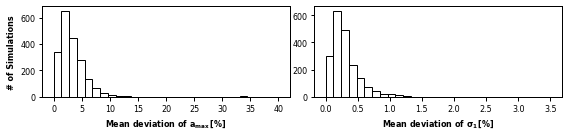

In [36]:
fig = plt.figure(figsize=(8,2))

outer  = gridspec.GridSpec(1, 1, figure=fig, wspace=0.0)
inner1 = outer[0].subgridspec(1, 2, wspace=0.1, hspace=0.05)
ax0  = fig.add_subplot(inner1[0])
ax1  = fig.add_subplot(inner1[1])

ax0.hist(np.ma.masked_where(deviation_a>1000,np.ma.masked_where(deviation_a <0, deviation_a)).compressed(), bins=np.linspace(0,40,30), fill=False)
# ax0.set_xlabel(r"$\mathbf{100\times\left\langle\frac{a_{max,act}-a_{max,pred}}{a_{max,act}}\right\rangle_t}$")
ax0.set_xlabel(r"Mean deviation of $\mathbf{a_{max} \,  [\%]}$")
ax0.set_ylabel('# of Simulations')

ax1.hist(np.ma.masked_where(deviation_sig>1000,np.ma.masked_where(deviation_sig <0, deviation_sig)).compressed(), bins=np.linspace(0,3.5,30), fill=False)
ax1.set_xlabel(r"Mean deviation of $\mathbf{\sigma_1 \,  [\%]}$")

outer.tight_layout(fig)

plt.savefig("Deviations.pdf", bbox_inches='tight')

# Create Torch Scipt Model

In [36]:
exnum = 8000
i = 150*exnum
example = Twopop_normed[i]

traced_script_module = torch.jit.trace(model, example)

traced_script_module.save("traced_model.pt")

In [38]:
exnum2 = 8000
i2 = 150*exnum2
example2 = Twopop_normed[i2]

output = traced_script_module(example2)
output

tensor([0.2592, 0.1716], grad_fn=<AddBackward0>)

In [39]:
output = model(example2)
output

tensor([0.2592, 0.1716], grad_fn=<AddBackward0>)

In [40]:
example2

tensor([6.0783e-01, 8.7641e-01, 1.4167e-01, 5.0360e-02, 1.9867e-01, 5.0360e-02,
        2.4638e-01, 7.1286e-04, 2.9334e-01, 4.9835e-02, 2.1497e-01, 7.7003e-04,
        1.8810e-01, 2.4910e-07])